In [1]:
import pandas as pd

In [2]:
data = pd.read_excel('./output/hasil-pos-tagging.xlsx')
data_pos = set()
data['pos'].dropna().apply(lambda x: data_pos.update([word.split('/')[-1] for word in x.split()]))
print("List POS Tag : ", data_pos)

List POS Tag :  {'ASP', 'VSA', 'PP1', 'NSD', 'M--', 'NSM', 'CO-', 'W--', 'G--', 'CC-', 'X--', 'S--', 'O--', 'PS2', 'PS3', 'T--', 'F--', 'B--', 'R--', 'VSP', 'Z--', 'H--', 'ASS', 'D--'}


In [3]:
from collections import Counter

In [28]:
pos_counter = Counter()
data['pos'].dropna().apply(lambda x: pos_counter.update([word.split('/')[-1] for word in x.split()]))

# Menampilkan hasil
pos_freq = sorted(pos_counter.items(), key=lambda x: x[1], reverse=True)
print("Frekuensi label POS:")
for label, freq in pos_freq:
    print(f"{label}: {freq}")

Frekuensi label POS:
NSD: 758
Z--: 206
R--: 201
VSA: 201
X--: 128
S--: 124
ASP: 114
O--: 94
VSP: 77
B--: 55
CC-: 49
H--: 35
F--: 31
D--: 25
G--: 20
PS3: 20
M--: 11
T--: 7
W--: 4
ASS: 4
NSM: 3
PP1: 3
CO-: 2
PS2: 1


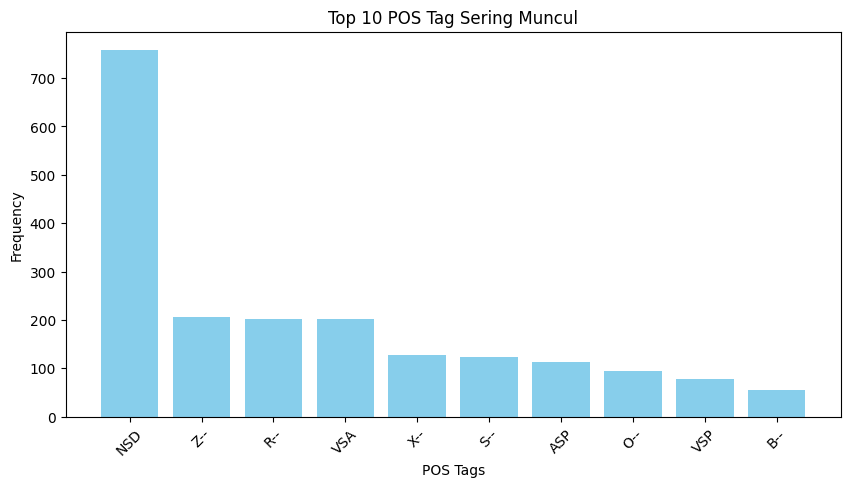

In [ ]:
import matplotlib.pyplot as plt

# ambil 10 POS yang paling sering muncul
top_n = 10
labels, counts = zip(*pos_freq[:top_n])

plt.figure(figsize=(10, 5))
plt.bar(labels, counts, color='skyblue')
plt.xlabel("POS Tags")
plt.ylabel("Frequency")
plt.title(f"Top {top_n} POS Tag Sering Muncul")
plt.xticks(rotation=45)
plt.show()


In [9]:
# distribusi pos per soal
def get_pos_distribution(pos_text):
    pos_list = [word.split('/')[-1] for word in pos_text.split()]
    return dict(Counter(pos_list))

In [12]:
data['pos-dist'] = data['pos'].dropna().apply(get_pos_distribution)

In [16]:
for idx, row in data.head(6).iterrows():  # Tampilkan 6 soal pertama
    print(f"Soal {idx+1}: {row['soal']}")
    print(f"Distribusi POS: {row['pos-dist']}")
    print("-" * 50)

Soal 1: Bagian dari bidang biologi yang membutuhkan penggunaan mikroskop, sebagai contoh
Distribusi POS: {'NSD': 5, 'R--': 2, 'S--': 1, 'VSA': 1, 'X--': 1, 'Z--': 1}
--------------------------------------------------
Soal 2: Dalam studi biologi, penggunaan mikroskop diperlukan untuk mempelajari hal seperti
Distribusi POS: {'NSD': 5, 'Z--': 1, 'X--': 1, 'VSP': 1, 'R--': 2, 'VSA': 1}
--------------------------------------------------
Soal 3: Ilmu biologi yang membutuhkan penggunaan mikroskop untuk mengkaji, sebagai contoh
Distribusi POS: {'NSD': 4, 'S--': 1, 'VSA': 2, 'X--': 1, 'R--': 2, 'Z--': 1}
--------------------------------------------------
Soal 4: Cabang biologi yang mendorong peneliti untuk menghasilkan bibit unggul melalui hibridisasi (persilangan) 
Distribusi POS: {'NSD': 5, 'S--': 1, 'VSA': 2, 'R--': 2, 'ASP': 1, 'X--': 1, 'Z--': 2}
--------------------------------------------------
Soal 5: Cabang ilmu biologi yang menjadi dasar bagi peneliti dalam mengembangkan bibit unggul 

In [20]:
import numpy as np
from difflib import SequenceMatcher
from scipy.spatial.distance import cosine
from sklearn.feature_extraction.text import CountVectorizer

In [21]:
# ekstrak versi soal ori dan augmen
def extract_quest_info(version_soal):
  quest_id, version = version_soal.split('v')
  return int(quest_id), int(version)


In [22]:
data[['question_id', 'version']] = data['version-soal'].apply(lambda x: pd.Series(extract_quest_info(x)))


In [23]:
# pisah ori dengan augmen
original = data[data['version'] == 1]
augmented = data[data['version'] > 1]

In [34]:
# gabung berdasar id soal
merged = original[['question_id', 'pos-dist', 'pos', 'current-prob']].rename(columns={'pos-dist': 'pos-dist-original', 'pos': 'pos-original'}).merge(
    augmented[['question_id', 'version', 'pos-dist', 'pos', 'current-prob']],
    on='question_id',
    how='inner'
)


In [35]:
# lihat kesamaan POS
# 1. Levenshtein Similarity  
def levenshtein_similarity(seq1, seq2):
    return SequenceMatcher(None, seq1, seq2).ratio()

# 2. Jaccard Similarity  
def jaccard_similarity(pos1, pos2):
    set1, set2 = set(pos1), set(pos2)
    return len(set1 & set2) / len(set1 | set2)

# 3. Cosine Similarity  
def cosine_similarity(pos1, pos2):
    vectorizer = CountVectorizer(tokenizer=lambda txt: txt.split())
    vectors = vectorizer.fit_transform([' '.join(pos1), ' '.join(pos2)]).toarray()
    return 1 - cosine(vectors[0], vectors[1])

In [36]:
merged['levenshtein_sim'] = merged.apply(lambda row: levenshtein_similarity(
    row['pos-original'].split(), row['pos'].split()), axis=1)

merged['jaccard_sim'] = merged.apply(lambda row: jaccard_similarity(
    row['pos-original'].split(), row['pos'].split()), axis=1)

merged['cosine_sim'] = merged.apply(lambda row: cosine_similarity(
    row['pos-original'].split(), row['pos'].split()), axis=1)

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\feature_extraction\text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [37]:
# Tampilkan hasil
print(merged[['question_id', 'version', 'levenshtein_sim', 'jaccard_sim', 'cosine_sim']])

# Simpan hasil ke file baru untuk analisis lebih lanjut
merged.to_excel('./output/hasil_perbandingan_pos.xlsx', index=False)

     question_id  version  levenshtein_sim  jaccard_sim  cosine_sim
0              1        2         0.272727     0.222222    0.363636
1              1        3         0.727273     0.571429    0.727273
2              2        2         0.551724     0.380952    0.552052
3              2        3         0.387097     0.291667    0.453743
4              4        2         0.600000     0.526316    0.688847
..           ...      ...              ...          ...         ...
97           114        3         0.571429     0.400000    0.667424
98           115        2         0.500000     0.500000    0.752618
99           115        3         0.272727     0.222222    0.545455
100          116        2         0.428571     0.285714    0.566947
101          116        3         0.413793     0.227273    0.608581

[102 rows x 5 columns]
